**Анализ результатов А/В теста по изучению влияния  улучшенной рекомендательной  системы на метрики деятельности интернет-магазина.**

Некий интернет магазин (характер деятельности не раскрыт) провёл тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. 
Техническое задание:
* Название теста: recommender_system_test ;
* группы: А — контрольная, B — новая платёжная воронка;
* дата запуска: 2020-12-07;
* дата остановки набора новых пользователей: 2020-12-21;
* дата остановки: 2021-01-04;
* аудитория: 15% новых пользователей из региона EU;
* назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* ожидаемое количество участников теста: 6000;
* ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page ,
- просмотры корзины — product_cart ,
- покупки — purchase .

## Предварительная обработка данных

In [1]:
# импортировали все использованные в проекте библиотеки
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

In [2]:
# прочитали все файлы
participants = pd.read_csv('/datasets/final_ab_participants.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
events = pd.read_csv('/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')

### Сведения о участниках теста

In [3]:
# ознакомились с данными 
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [4]:
# проверили на пропуски
print(participants.isna().mean())
# проверили на явные дубликаты
print(participants.duplicated().sum())
# посмотрели количество уникальных пользователей
print(participants['user_id'].nunique())

user_id    0.0
group      0.0
ab_test    0.0
dtype: float64
0
16666


In [5]:
# какие тесты представлены в файле
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В датафрейме имеются данные о проведении двух тестов.

In [6]:
# распределение пользователей по группам в разных тестах
participants.pivot_table(index='group', columns='ab_test', values='user_id', aggfunc='nunique',).reset_index()

ab_test,group,interface_eu_test,recommender_system_test
0,A,5831,3824
1,B,5736,2877


Оказалось, что в таблице сведения о тестировании двух новшеств: изменение интерфуйса и изменения рекомендательной системы. Интерфейс - тест более мощный и группы равномерно распределены. Проверили наличие пользователей, которые участвуют сразу в двух экспериментах.

In [7]:
# количество пользователей, попавших в оба теста
participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').shape[0]


1602

Участие пользователей в двух тестах не критично, если тесты проводились в разное время. Разделили таблицу на две, для каждого теста свою. Проверили наличие пользователей, которые попали в две группы внутри одного теста.

In [8]:
interface = participants.query('ab_test == "interface_eu_test"')
interface = interface.drop('ab_test', axis=1)

recommender = participants.query('ab_test == "recommender_system_test"')
recommender = recommender.drop('ab_test', axis=1)
# проверили наличие пользователей, которые включены в две группы в пределах одного теста
print('Одновременно в двух группах тест interface', interface.groupby('user_id').agg({'group':'nunique'}).query('group > 1').shape[0])
print('Одновременно в двух группах тест recommender', recommender.groupby('user_id').agg({'group':'nunique'}).query('group > 1').shape[0])
print('Количество пользователей, участвующих в интерфейс-тесте', interface['user_id'].nunique())
print('Количество пользователей, участвующих в рекомендации-тесте', recommender['user_id'].nunique())

Одновременно в двух группах тест interface 0
Одновременно в двух группах тест recommender 0
Количество пользователей, участвующих в интерфейс-тесте 11567
Количество пользователей, участвующих в рекомендации-тесте 6701


In [9]:
# количество пользователей, участвующих в двух тестах в группе "B" 
bb = participants.query('group == "B"').groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').reset_index()
bb

,user_id,ab_test
0,001064FEAAB631A1,2
1,010DB4614355A4BB,2
2,020A95B66F363AFB,2
3,022A97E4F285BD73,2
4,02A553C0C9716E82,2
...,...,...
339,FC37CBE8211E02A8,2
340,FD2E811B409ADB85,2
341,FF7BE2897FC0380D,2
342,FF9A81323FA67D6E,2


Если тесты проводятся в одно время, то попадание пользователя в группу "В" в двух тестах одновременно будет означать, что на изменение его поведения одновременно влияют 2 фактора и разделить это влияние невозможно. Полагаем, что в группе "А" всегда находятся пользователи, которым не предлагают никаких новшеств. В принципе, группа "А" может быть общей для нескольких испытаний.

**Вывод**

    Данные о участниках теста содержат сведения о проведении двух тестов, 1602 пользователя приняли участие в двух тестах одновременно. Если тесты проводили в разное время, то на результаты тестирования это не повлияет. Нет участников, включенных в обе группы внутри одного теста. Название интерфейс-теста `interface_eu_test` намекает, что его проводили среди пользователей из Евросоюза.
    
    Вопрос о исключении из исследования пользователей, оказавшихся в двух тестах, целесообразно решить после присоединения сведений о регистрации новых пользователей.     

### Сведения о новых пользователях, зарегистрировавшихся с начала теста.

In [10]:
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


структура файла neW_users новые пользователи, зарегистрировавшиеся с начала теста
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

In [11]:
# посмотрели регионы проведения теста
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [12]:
# По техническому заданию "аудитория: 15% новых пользователей из региона EU", оставили для исследования
# пользователей из 'EU'.
new_users = new_users.query('region == "EU"')

In [13]:
# проверили на пропуски
print(new_users.isna().mean())
# проверили на явные дубликаты
print(new_users.duplicated().sum())
# посмотрели количество уникальных пользователей
print(new_users['user_id'].nunique())

user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64
0
46270


In [14]:
print(new_users['user_id'].nunique()*0.15)

6940.5


Для выполнения условия  ТЗ, что аудитория теста: 15% новых пользователей из региона EU, размер выборки 6000 выполняется. Удалили колонки region (оставили только один регион) и device (для выполнения ТЗ сведения об устройстве не понадобятся), поменяли тип данных о времени.

In [15]:
new_users = new_users.drop(columns=['region', 'device'])
# поменяли тип данных first_date
new_users['first_date'] = new_users['first_date'].astype('datetime64')
new_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46270 entries, 0 to 61732
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     46270 non-null  object        
 1   first_date  46270 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.1+ MB


Проверили на соответствие ТЗ времени регистрации пользователей: дата запуска 07.12.2020, дата остановки набора новых пользователей 21.12.2020 года 

In [16]:
print(new_users['first_date'].min())
print(new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


Два дня набора новых пользователей выпадают из условия ТЗ. Исключили тех, кто зарегистрировался позже срока, установленного ТЗ  

In [17]:
new_users = new_users.query('first_date <= "2020-12-21"')
new_users['user_id'].nunique()

42340

In [18]:
print(new_users['first_date'].min())
print(new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-21 00:00:00


Удаление пользователей, зарегистрированных в Евросоюзе за два предрождественских  дня 22 и 23 декабря уменьшило выборку до 42340 пользователей.

In [19]:
# количество пользователей после удаления зарегистрированных вне диапзона, установленного ТЗ
new_users['user_id'].nunique()

42340

**Вывод**

В датафрейме о регистрации новых пользователей поменяли тип данных о времени. Пропусков и дубликатов не обнаружили.
Руководствуясь условиями ТЗ из таблицы исключили пользователей из других регионов кроме Евросоюза, пользователей, зарегистрированных после даты остановки набора, установленной ТЗ, и колонки region и device. Получили сведения о 42340 пользователях.

### Cведения о событиях

In [20]:
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Структура файла events
- user_id — идентификатор пользователя;
- event_dt — дата и время покупки;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

In [21]:
# поменяли тип данных events_dt
events['event_dt'] = events['event_dt'].astype('datetime64')
# избавились от колонки details, изучение данных о подробностях стоимости покупки не входят в задачу
events = events.drop('details', axis=1)
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 10.1+ MB


In [22]:
# проверили на пропуски и дубликаты
print(events.isna().mean())
print(events.duplicated().sum())
# количество уникальных пользователей
print(events['user_id'].nunique())

user_id       0.0
event_dt      0.0
event_name    0.0
dtype: float64
0
58703


In [23]:
print(events['event_dt'].min())
print(events['event_dt'].max())

2020-12-07 00:00:33
2020-12-30 23:36:33


Согласно ТЗ дата остановки  2021-01-04. Фактически сведения о событиях представлены по 30 декабря 2020 года. Мы не можем изменить данные, чтобы они соотвествовали условию ТЗ и сообщим, что фактически дата остановки наблюдений - полночь 2020-12-30.

In [24]:
# какие события совершали пользователи
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

В логе всего 4 вида событий:
- 'login' вход в сиситему,
- 'product_page' продуктовая страница,
- 'product_cart' продуктовая корзина,
- 'purchase' поупка.

**Выводы**

Данные о событиях содержат сведения о событиях, совершенных 58703 пользователями в период с 7 декабря по 30 декабря 2020 года. Поменяли тип данных о времени события. пропусков и дубликатов на обнаружили.

### Сведения о маркетинговых событиях    

In [25]:
marketing_events.info()
marketing_events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Сруктура файла маркетинговых событий:
- name — название маркетингового события; 
- regions — регионы, в которых будет проводиться рекламная кампания; 
- start_dt — дата начала кампании; 
- finish_dt — дата завершения кампании.

На поведение пользователей, включенных в наше исследование,  могут повлиять маркетинговые ходы, действие которых приходится на время проведения теста и  распространяется на Евросоюз.  Исключив из рассмотрения периоды, когда проводились акции, можно неоправдано урезать массив данных. Время проведения теста выбрано не очень удачно, оно совпадает с кануном Рождества и Нового года, это период максимальной маркетинговой активности.

**Выводы**

Имея в виду, что влияние маркетинговых событий на поведение пользователей в различных группах статистически будет одинаковым, отказались связывать маркетинговые события и данные о результатах теста. Иными словами маркетинговые события могут изменять поведение пользователей в одинаковой мере для группы А и группы В. 

## Исследовательский анализ данных

### Объеднение таблиц. Проверка соблюдения технического задания и корректности проведения теста.

Подготовили данные о пользователях из трех таблиц. Сведения о уникальных номерах пользователей, участвующих в тесте recommender, и группе теста, содержатся в таблице `recommender`, данные о регистрации новых пользователей в таблице `new_users`, сведения о событиях содержатся в таблице `events`. Последовательно объединили данные из трех источников по user_id методом `merge`. По умолчанию объединение идёт только по совпадающим `user_id`. Таким образом, отсеяли пользователей с неполным набором данных, необходимых для анализа результатов теста.

In [26]:
# прсоединили к пользователям, участвующим в тесте recommender, сведения о  дате регистрации
df_re = recommender.merge(new_users)
print('Количество пользователей в тесте recommender после присоединения даты регистрации',df_re['user_id'].nunique())
df_re.head()


Количество пользователей в тесте recommender после присоединения даты регистрации 6351


,user_id,group,first_date
0,D1ABA3E2887B6A73,A,2020-12-07
1,A7A3664BD6242119,A,2020-12-20
2,DABC14FDDFADD29E,A,2020-12-08
3,04988C5DF189632E,A,2020-12-14
4,482F14783456D21B,B,2020-12-14


In [27]:
# присоединили данные о событиях к recommender
df_re = df_re.merge(events)
print('Количество пользователей в тесте recommender после присоединения информации о событиях', df_re['user_id'].nunique())
df_re.head()

Количество пользователей в тесте recommender после присоединения информации о событиях 3481


,user_id,group,first_date,event_dt,event_name
0,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,purchase
1,D1ABA3E2887B6A73,A,2020-12-07,2020-12-25 00:04:56,purchase
2,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:29,product_cart
3,D1ABA3E2887B6A73,A,2020-12-07,2020-12-25 00:04:57,product_cart
4,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,product_page


In [28]:
# разделение по группам в тесте recommender
df_re.pivot_table(index='group', values='user_id', aggfunc='nunique',).reset_index()

,group,user_id
0,A,2604
1,B,877


Данные о регистрации новых пользователей и, особенно о событиях, оказались не полными, из 6701 пользователей, обозначенных, как участники теста recommender, для анализа осталось только 3481, контрольная группа "А" почти в 3 раза превышает экспериментальную группу "В", что может отрицательно отразится на результате.

Проверили, не остались ли в выборке пользователи, которые одновременно участвуют сразу в двух тестах. Для этого взяли датафрейм пользователей - участников теста interface. Присоединили к нему даты регистрации и события пользователей по уникальным номерам пользователей и нашли пересечение таблиц двух разных тестов.

In [29]:
# прсоединили к пользователям, участвующим в тесте interface, сведения о  дате регистрации
df_in = interface.merge(new_users)
print('Количество пользователей в тесте interface',df_in['user_id'].nunique())
df_in.head()

Количество пользователей в тесте interface 10565


,user_id,group,first_date
0,773ECB64E45DEBAB,A,2020-12-07
1,6BCB0F33D3BAB8C2,A,2020-12-21
2,AABA4219186465C9,A,2020-12-13
3,2BA8FA8754D1FE50,B,2020-12-09
4,FB6F6BC119E1DBD5,B,2020-12-18


Назначение группы и теста проходило в едином цикле и поэтому оба теста в одном массиве данных.

In [30]:
# присоединили данные о событиях к interface
df_in = df_in.merge(events)
print(df_in['user_id'].nunique())
df_in.head()

9848


,user_id,group,first_date,event_dt,event_name
0,6BCB0F33D3BAB8C2,A,2020-12-21,2020-12-21 21:07:21,product_page
1,6BCB0F33D3BAB8C2,A,2020-12-21,2020-12-28 00:32:15,product_page
2,6BCB0F33D3BAB8C2,A,2020-12-21,2020-12-21 21:07:18,login
3,6BCB0F33D3BAB8C2,A,2020-12-21,2020-12-28 00:32:13,login
4,FB6F6BC119E1DBD5,B,2020-12-18,2020-12-18 05:10:22,product_page


In [31]:
# разделение по группам в тесте interface
df_in.pivot_table(index='group', values='user_id', aggfunc='nunique').reset_index()

,group,user_id
0,A,4978
1,B,4870


Неполнота данных о регистрации пользователей и событиях отразилась и на interface тесте. но в меньшей мере. Количество пользователей, приписанных к нему составило 11567, после присоединения данных оказалось, что сведения для анализа имеются только для 9848. Пользователи по группам в этом тесте распределены равномерно, группы большие, жаль, что мы проверяем не interface тест.

Очевидно, что два теста проходили одновременно, если пользователю одновременно предлагают два новшества, то не известно какое из них оказало влияние на изменение поведения. Если пользователи попали в оба теста в группу "А", то не страшно, их вообще не соблазняли никакими новшествами,  хорошая группа "А" может быть одной на несколько одновременных тестов. Главное, чтобы на одном пользователе не испытывали сразу несколько нововведений. 

Чтобы исключить пользователей, которым и интерфейс поменяли и рекомендаций новых дали, объединили таблицы по двум тестам, появился массив данных перекресных пользователей. Из него выбрали всех, кто оказался в группе "В"

In [32]:
# объединили таблицы двух тестов, что найти общих пользователей для двух тестов
df_s = pd.merge(df_re, df_in, left_on='user_id', right_on='user_id', how='inner')
print(df_s['user_id'].nunique())
df_s

887


,user_id,group_x,first_date_x,event_dt_x,event_name_x,group_y,first_date_y,event_dt_y,event_name_y
0,DABC14FDDFADD29E,A,2020-12-08,2020-12-08 11:30:58,login,A,2020-12-08,2020-12-08 11:30:58,login
1,DABC14FDDFADD29E,A,2020-12-08,2020-12-08 11:30:58,login,A,2020-12-08,2020-12-11 12:52:32,login
2,DABC14FDDFADD29E,A,2020-12-08,2020-12-08 11:30:58,login,A,2020-12-08,2020-12-18 11:10:45,login
3,DABC14FDDFADD29E,A,2020-12-08,2020-12-11 12:52:32,login,A,2020-12-08,2020-12-08 11:30:58,login
4,DABC14FDDFADD29E,A,2020-12-08,2020-12-11 12:52:32,login,A,2020-12-08,2020-12-11 12:52:32,login
...,...,...,...,...,...,...,...,...,...
51687,FA86D8DFAD3ADADE,A,2020-12-14,2020-12-20 23:14:52,login,A,2020-12-14,2020-12-14 18:13:37,login
51688,FA86D8DFAD3ADADE,A,2020-12-14,2020-12-20 23:14:52,login,A,2020-12-14,2020-12-15 06:56:40,login
51689,FA86D8DFAD3ADADE,A,2020-12-14,2020-12-20 23:14:52,login,A,2020-12-14,2020-12-17 16:13:19,login
51690,FA86D8DFAD3ADADE,A,2020-12-14,2020-12-20 23:14:52,login,A,2020-12-14,2020-12-20 23:14:52,login


Если пользователь в обоих тестах попал в группу "А", это не приводит к искажению данных; 

если в нашем тесте группа "В", а в конкурирующем тесте группа "А", то нам это тоже не помешает, ничего лишнего ему не предложат;

если в нашем тесте группа "А", а в интерфейс-тесте группа"В", то нашему пользователю предлагают новый интерфейс, что будет оказывать нецелевое воздействие на пользователя, таких пользователей надо удалить;

если в двух тестах группа "В", то пользователь подвергается двойному воздействию, их тоже надо удалить 

In [33]:
# получили список пользователей, попавших в группу "В" в двух тестах или в группу "А" в нашем тесте 
# и группу "В" в конкурирующем
df_sc = df_s.query('(group_x == "B" & group_y == "B") or (group_x == "A" & group_y == "B")')
df_sc['user_id'].nunique()

431

In [34]:
# исключили 431 двойных агентов из recommender теста
exit = df_sc['user_id']
df_re = df_re.query('~(user_id in @exit)')
print(df_re['user_id'].nunique())
df_re.pivot_table(index='group', values='user_id', aggfunc='nunique',).reset_index()

3050


,group,user_id
0,A,2279
1,B,771


После исключения пользователей, которые могут исказить результаты из-за участия в двух тестах одновременно, для анализа осталась выборка размером 3050 человек, размер контрольной группы почти в три раза превышает размер экспериментальной.

In [35]:
df_re

,user_id,group,first_date,event_dt,event_name
0,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,purchase
1,D1ABA3E2887B6A73,A,2020-12-07,2020-12-25 00:04:56,purchase
2,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:29,product_cart
3,D1ABA3E2887B6A73,A,2020-12-07,2020-12-25 00:04:57,product_cart
4,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,product_page
...,...,...,...,...,...
23415,80712ED4EA1B52A5,A,2020-12-14,2020-12-15 20:10:06,product_page
23416,80712ED4EA1B52A5,A,2020-12-14,2020-12-20 20:01:34,product_page
23417,80712ED4EA1B52A5,A,2020-12-14,2020-12-14 05:48:50,login
23418,80712ED4EA1B52A5,A,2020-12-14,2020-12-15 20:10:03,login


В техническом задании есть условие о том, что эффект от новшества должен проявиться за 14 дней с момента регистрации. Для выполнения этого условия надо исключить события, совершенные  пользователем позже 14 дней с момента регистрации. Создали колонку liftime, в которой записали разницу между датой регистрации и конкретным событием. Отобрали  события, которые укладываюся в условия теста, то есть совершены в пределах 14 дней после регистрации пользователя.

In [36]:
# добавляем  колонку с промежутком времени от регистрации пользователя до данного события
df_re['lifetime'] = (df_re.event_dt - df_re.first_date)
df_re

,user_id,group,first_date,event_dt,event_name,lifetime
0,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,purchase,0 days 14:43:27
1,D1ABA3E2887B6A73,A,2020-12-07,2020-12-25 00:04:56,purchase,18 days 00:04:56
2,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:29,product_cart,0 days 14:43:29
3,D1ABA3E2887B6A73,A,2020-12-07,2020-12-25 00:04:57,product_cart,18 days 00:04:57
4,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,product_page,0 days 14:43:27
...,...,...,...,...,...,...
23415,80712ED4EA1B52A5,A,2020-12-14,2020-12-15 20:10:06,product_page,1 days 20:10:06
23416,80712ED4EA1B52A5,A,2020-12-14,2020-12-20 20:01:34,product_page,6 days 20:01:34
23417,80712ED4EA1B52A5,A,2020-12-14,2020-12-14 05:48:50,login,0 days 05:48:50
23418,80712ED4EA1B52A5,A,2020-12-14,2020-12-15 20:10:03,login,1 days 20:10:03


In [37]:
# исключаем события, которые совершены за пределами 14 дней от даты регистрации
df_re_lt = df_re.query('lifetime <= "14 days 00:00:00"')
print(df_re_lt['user_id'].nunique())
print(df_re_lt.pivot_table(index='group', values='user_id', aggfunc='nunique',).reset_index())
df_re_lt


3050
  group  user_id
0     A     2279
1     B      771


,user_id,group,first_date,event_dt,event_name,lifetime
0,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,purchase,0 days 14:43:27
2,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:29,product_cart,0 days 14:43:29
4,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,product_page,0 days 14:43:27
6,D1ABA3E2887B6A73,A,2020-12-07,2020-12-07 14:43:27,login,0 days 14:43:27
8,A7A3664BD6242119,A,2020-12-20,2020-12-20 15:46:06,product_page,0 days 15:46:06
...,...,...,...,...,...,...
23415,80712ED4EA1B52A5,A,2020-12-14,2020-12-15 20:10:06,product_page,1 days 20:10:06
23416,80712ED4EA1B52A5,A,2020-12-14,2020-12-20 20:01:34,product_page,6 days 20:01:34
23417,80712ED4EA1B52A5,A,2020-12-14,2020-12-14 05:48:50,login,0 days 05:48:50
23418,80712ED4EA1B52A5,A,2020-12-14,2020-12-15 20:10:03,login,1 days 20:10:03


Фильтрацияя по продолжительности лайфтфйма привела к сокращению числа событий на 715 строк, но не повлияла на количество пользователей и распределение их по группам теста.

**Техническое задание**

Название теста: recommender_system_test;

Группы: А (контрольная), B (новая платёжная воронка);

**Дата запуска: 2020-12-07.  Выполняется.**

**Дата остановки набора новых пользователей: 2020-12-21.** После исключения пользователей, зарегистрированных 22 и 23 декабря это **условие выполнено**;

**Дата остановки: 2021-01-04.** Фактически имеются записи только до полуночи 2020-12-30. Условие ТЗ о дате остановки не выполнено. **Фактически дата остановки:  2020-12-30**

**Аудитория: 15% новых пользователей из региона EU.** Все новые пользователи из  региона EU, 15% из них равны 6940 пользователей. **Фактически аудитория составила 7% пользователей из региона EU.**

**Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы**

**Ожидаемое количество участников теста: 6000, реальное количество участников теста 3375.** 

**Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%**, проверен ниже. 

**Вывод**

Для проверки ожидаемого эффекта получили данные о 19849 событиях, совершенных 3050 пользователями с 7 по 30 декабря 2020 года. Группа "А" 2279 пользователя, группа "В" 771 пользователей.

Не выполнены условия теста о дате остановки, размере аудитории, ожидаемом количестве участников.

Влияние маркетинговых событий не учитывали по следующим причинам:
- Накануне Рождества и Нового года они непрерывны. Исключая даты проведения акций можно потерять большой массив и без того скромных  данных. 
- Маркетинговые события одинаково действуют на поведение пользователей контрольной и экспериментальной групп.

### Исследование пользовательского поведения

In [38]:
print('Количество пользователей', df_re['user_id'].nunique())
print('Среднее количество событий на одного пользователя', round(df_re.shape[0]/df_re['user_id'].nunique()))

Количество пользователей 3050
Среднее количество событий на одного пользователя 7


In [39]:
# посчитали количество событий, совершенных пользователем
count_event = df_re.groupby(['group', 'user_id'])['event_name'].count().sort_values().reset_index()
count_event

,group,user_id,event_name
0,A,6D88BE6410DBB984,1
1,B,FC2DA0D7EF375B27,1
2,B,95401934D6D6D4FC,1
3,A,921FFC6F0F506A82,1
4,B,DAEE6D470B64E11B,1
...,...,...,...
3045,A,6E3DF9C69A6B607E,21
3046,A,CED71698585A2E46,24
3047,A,1BFEE479308EFF44,24
3048,B,115EBC1CA027854A,27


Пользователи совершали от 1 до 28 событий за исследуемый период, в среднем 7 событий на пользователя

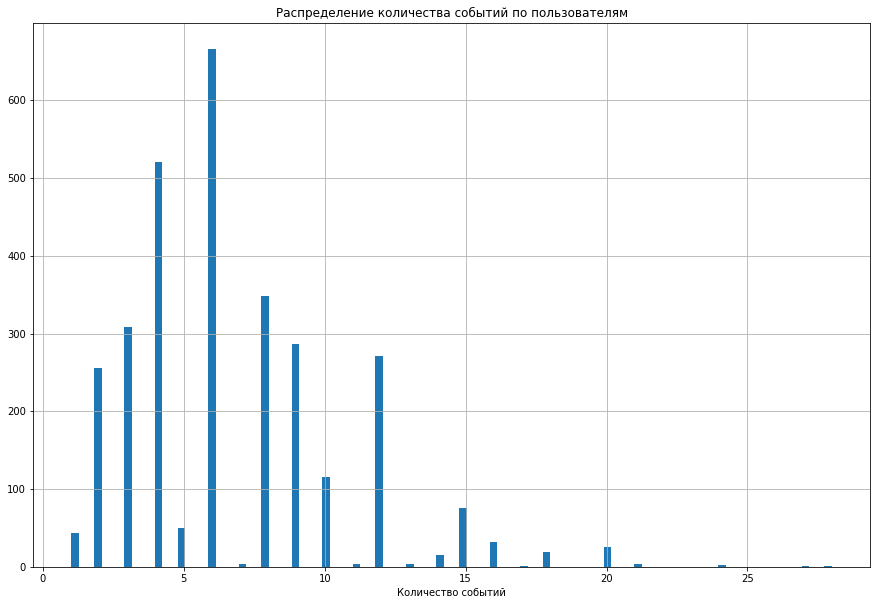

In [40]:
# гистограмма распределения количества событий за исследуемый период
count_event['event_name'].hist(bins=100, figsize=(15,10))
plt.title('Распределение количества событий по пользователям')
plt.xlabel('Количество событий')

plt.show();

In [41]:
# повернули таблицу, чтобы группы стали колонками
event_count = count_event.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')
event_count.fillna(0) 

group,A,B
event_name,,
1,27.0,16.0
2,162.0,94.0
3,196.0,112.0
4,365.0,156.0
5,36.0,14.0
6,508.0,158.0
7,0.0,3.0
8,283.0,65.0
9,223.0,64.0


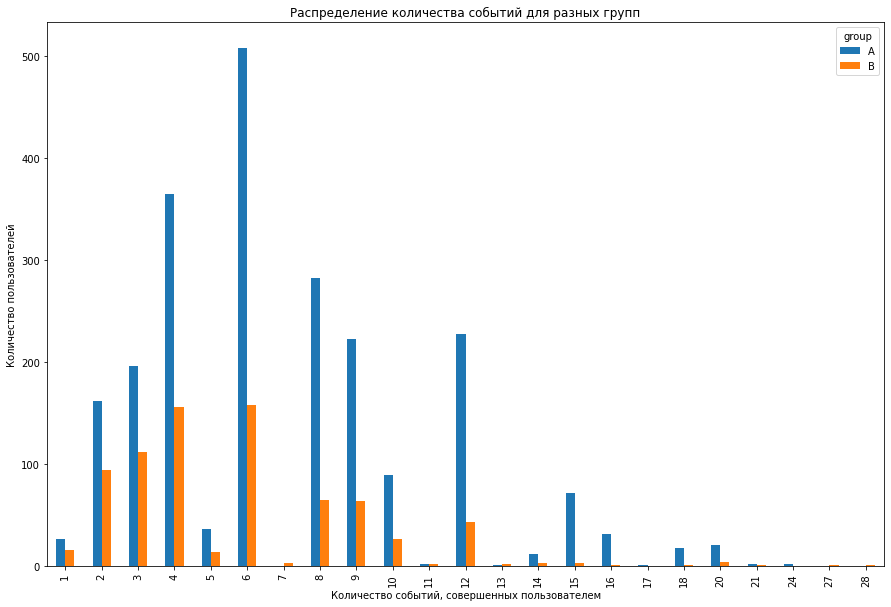

In [42]:
# построили столбчатую диаграмму распределения количества событий на пользователя для разных групп
plt.rcParams["figure.figsize"] = (15, 10)
#plt.figure(figsize=(15, 10))
event_count.plot.bar()
plt.title('Распределение количества событий для разных групп')
plt.xlabel('Количество событий, совершенных пользователем')
plt.ylabel('Количество пользователей')
plt.show();

Конфигурация распределения количества событий, совершенных одним пользователем, в обеих группах похожа, наглядно различие в размерах выборок А/В. Максимальное количество пользователей совершили по 6 событий за исследуемый период. Гистограмма демонстрирует неравномерное распределение по группам.

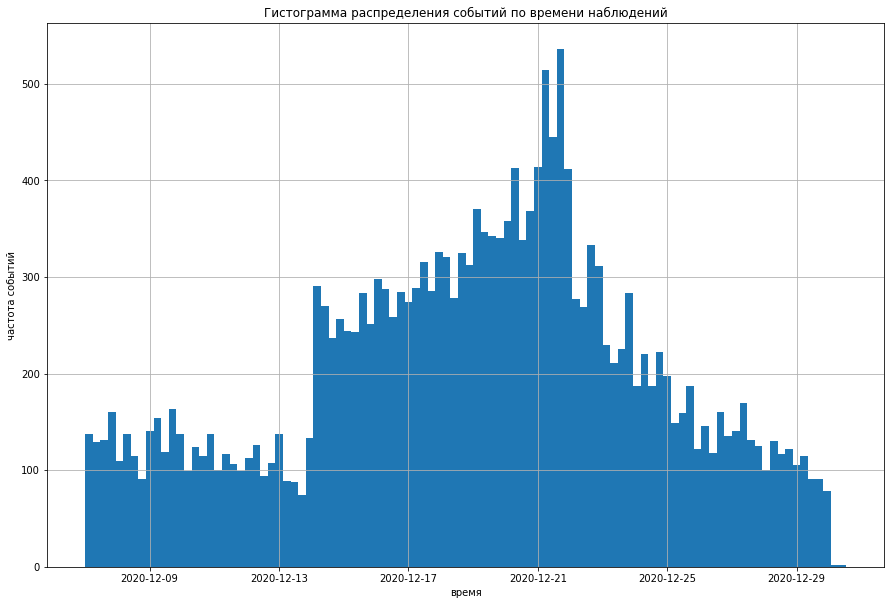

In [43]:
# построили гистограмму распределения событий по времени
df_re['event_dt'].hist(bins=100, figsize=(15,10))
plt.title('Гистограмма распределения событий по времени наблюдений')
plt.xlabel('время')
plt.ylabel('частота событий')
plt.show();

<AxesSubplot:>

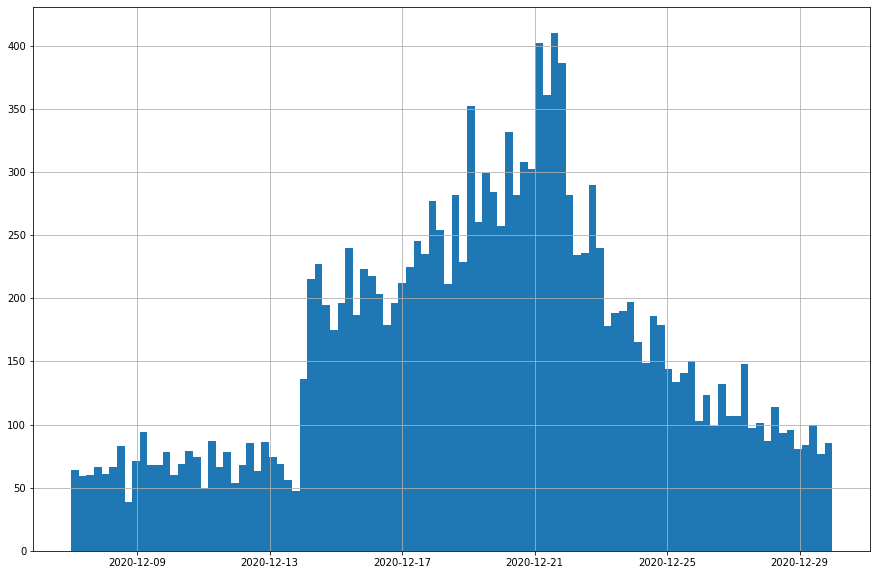

In [44]:
df_re.query('group == "A"')['event_dt'].hist(bins=100, figsize=(15,10))

<AxesSubplot:>

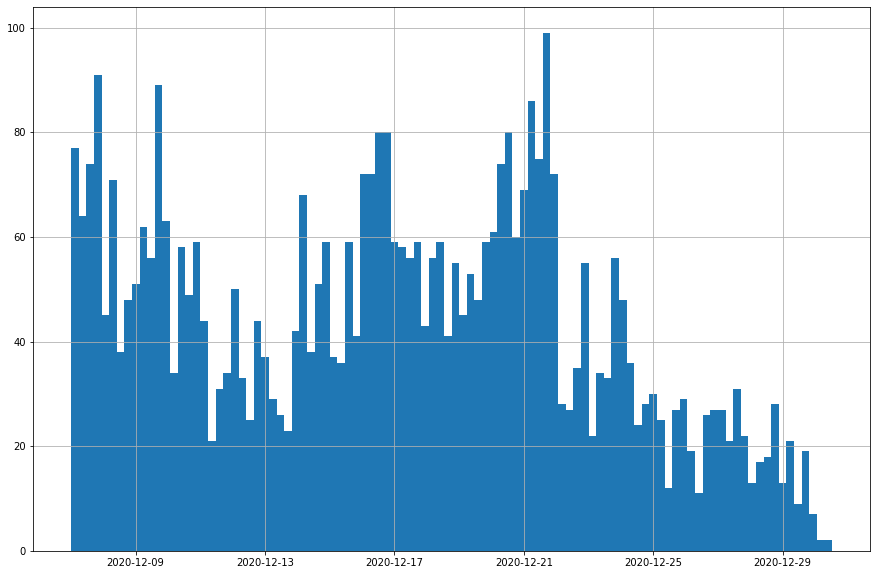

In [45]:
df_re.query('group == "B"')['event_dt'].hist(bins=100, figsize=(15,10))

Активность пользователей по времени проведения теста различается в группах. По выборке в целом и в контрольной группе "А" до 14 декабря активность низкая, 14 декабря наблюдается резкий скачек, далее растёт до 22 декабря и начинает быстро снижаться. В экспериментальной группе "В" в начале теста с 7 по 11 декабря активность довольно высокая, провал с 12 по 14 декабря, медленный рост до 22 и снижение до конца наблюдений. 

### Анализ результатов эксперимента

In [46]:
# посмотрели, как часто встречаются события
df_re['event_name'].value_counts()

login           9306
product_page    5740
purchase        2804
product_cart    2714
Name: event_name, dtype: int64

In [47]:
# посчитали количество пользователей, совершавших каждое из событий хотя бы один раз.
event_cast = df_re.pivot_table(index='event_name', values='user_id', aggfunc='nunique',).reset_index()
event_cast.columns = ['event', 'user_count']
event_cast['user_ratio'] = (event_cast['user_count'] /len(df_re['user_id'].unique())*100).round(2)
event_cast = event_cast.sort_values('user_count', ascending=False)
event_cast

,event,user_count,user_ratio
0,login,3050,100.00
2,product_page,1905,62.46
3,purchase,953,31.25
1,product_cart,900,29.51


In [48]:
# доля относительно предыдущего шага
event_cast['test'] = event_cast['user_count'] / event_cast['user_count'].shift()
event_cast

,event,user_count,user_ratio,test
0,login,3050,100.00,NaN
2,product_page,1905,62.46,0.624590
3,purchase,953,31.25,0.500262
1,product_cart,900,29.51,0.944386


Последовательность шагов пользователя в приложении выглядит следующим образом: авторизация - продуктовая страница - продуктовая корзина - покупка. Помещать товар в корзину не обязательно, можно сразу купить, поэтому количество пользователей, совершивших покупку меньше, чем тех, кто воспользовался корзиной. Хронологически корзина впереди покупки, но её некоторые пропускают.

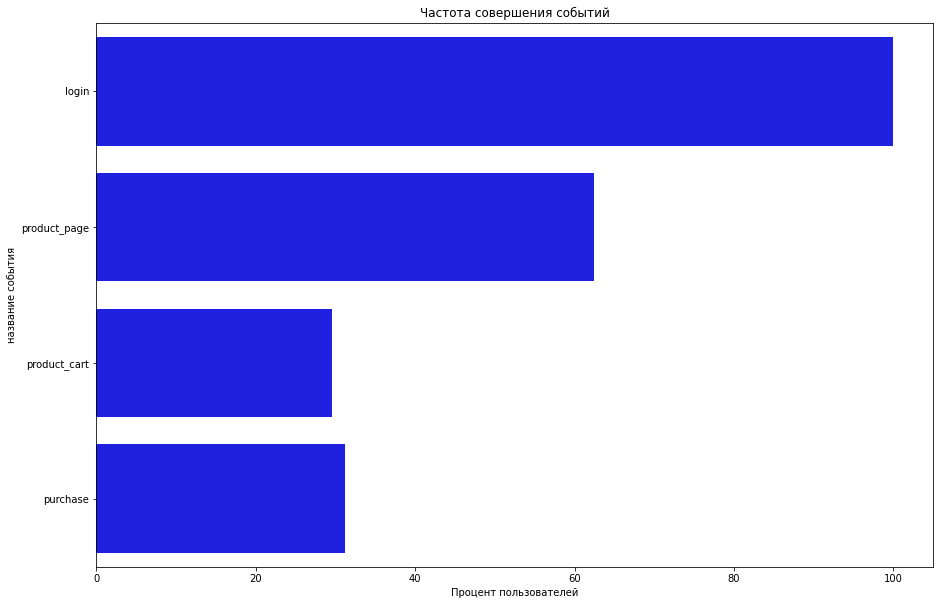

In [49]:
# строим воронку событий для всей выборки
order= ['login', 'product_page', 'product_cart', 'purchase']
plt.figure(figsize=(15,10))
ax = sns.barplot(x='user_ratio', y='event', data = event_cast, order = order, color='blue') 

plt.title('Частота совершения событий')

plt.xlabel('Процент пользователей')
plt.ylabel('название события')

plt.show();

## Анализ результатов эксперимента

In [50]:
# посмотрели число пользователей в каждой из  групп в разрезе событий
df_event = (df_re.pivot_table(
    index='event_name',
    columns='group', 
    values='user_id', 
    aggfunc='nunique')
           .sort_values('A', ascending=False).reset_index())
df_event = df_event.set_index('event_name')
df_event

group,A,B
event_name,,
login,2279,771
product_page,1476,429
purchase,734,219
product_cart,686,214


In [51]:
# создали колонку с числом пользователей в каждой группе
df_full = df_re.pivot_table(index='group', values='user_id', aggfunc='nunique',).reset_index()
df_full.columns = ['group', 'full']
df_full

,group,full
0,A,2279
1,B,771


In [52]:
# повернули таблицу и присоединили размеры групп
df_event = df_event.T
df = pd.merge(df_event, df_full, on='group')
df


,group,login,product_page,purchase,product_cart,full
0,A,2279,1476,734,686,2279
1,B,771,429,219,214,771


In [53]:
# посчитали конверсию различных действий для каждой группы 
df.iloc[:, [1, 2, 3, 4]] = df.iloc[:, [1, 2, 3, 4]].div(df.iloc[:, 5].values, axis=0)
df

,group,login,product_page,purchase,product_cart,full
0,A,1.0,0.647652,0.322071,0.301009,2279
1,B,1.0,0.556420,0.284047,0.277562,771


Конфуз, конверсии во все действия в контрольной группе выше, чем в эспериментальной. Что-то не то рекомендуют пользователям. 

**Вывод**

Ожидаемый эффект теста не оправдался!  За 14 дней с момента регистрации в системе пользователи показали **ухудшение** каждой метрики: 
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

Вместо ожидаемого улучшения метрик на 10%.

Между показателями конверсии групп А/B теста имеются отличия, являются ли они статистически значимыми проверили, используя z-тест. 

## Оценка результатов А/В теста

Оценили равенство долей уникальных посетителей в разных группах теста, побывавших на этапе воронки, используя z-тест.

**Нулевая гипотеза**: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

**Альтенативная гипотеза**: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница

In [54]:
# функция для z_testa
def z_test(successes1, successes2, trials1, trials2, alpha=0.05):

    p1 = successes1/trials1

    p2 = successes2/trials2

    p_combined = (successes1 + successes2) / (trials1 + trials2)

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))

    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [55]:
# количество пользователей для каждого этапа воронки в каждой группе,  количество пользователей в группе 
#равно количеству пользователей на этапе login

df_test = df_event.T
df_test

group,A,B
event_name,,
login,2279,771
product_page,1476,429
purchase,734,219
product_cart,686,214


Применили функцию z_test к каждой паре сравнения долей групп А / В.  В нашей воронке  является обязательным этап авторизации, его посещают 100% пользователей, но воронка допускает несколько вариантов последовательности  продвижения по воронке. Это значит, что для каждого шага воронки доля должна считаться от общего количества пользователей в группе. В нашем случае общее количество совпадает с количеством авторизировавшихся пользователей. 

In [56]:
#  переход от авторизации к продуктовой странице
z_test(df_test.at['product_page', 'A'], df_test.at['product_page', 'B'], df_test.at['login', 'A'], df_test.at['login', 'B'])

p-значение:  6.120730626113513e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [57]:
# переход от авторизации к продуктовой корзине
z_test(df_test.at['product_cart', 'A'], df_test.at['product_cart', 'B'], df_test.at['login', 'A'], df_test.at['login', 'B'])

p-значение:  0.21721122664962245
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [58]:
# переход от авторизации к покупке
z_test(df_test.at['purchase', 'A'], df_test.at['purchase', 'B'], df_test.at['login', 'A'], df_test.at['login', 'B'])

p-значение:  0.048942596376941205
Отвергаем нулевую гипотезу: между долями есть значимая разница


Между группой В, в которой пользовались новыми рекомендациями, и контрольной группой А, статистически значимые различия обнаружились на этапе перехода от авторизации к продуктовой странице и от авторизации к покупке. 

Обоснование выбора значимости.
В ходе исследования проведено 3 проверки статистических гипотез на равенство долей. Проверки проводили при помощи z-testa. Существует несколько методов снижения вероятности ложнопозитивного результата при множественном тестировании гипотез: метод Бонферрони (поправка Бонферрони), метод Холма, метод Шидака. Все они заключаются в снижении выбранного уровня значимости с ростом числа проверок. Чаще всего применяют поправку Бонферрони — из-за простоты решения. Надо поделить принятый уровень значимости на число сравнений, которые проводят на одних и тех же данных. В проведенном исследовании в двух случаях р-значение оказалось ниже выбранного  уровня значимости 0,05. Разделили его на 3 и получили уровень значимости 0,0167. При этом р-значения не изменятся, следовательно в случае продуктовой страницы нулевая гипотеза всё равно отвергнута и между долями есть разница, а в случае покупок, где р-зачение равно 0,049 не получится отвергнуть нулевую гипотезу и нет основания считать доли разными, так как 0,049>0,0167.

## Выводы

Проведен анализ результатов А/В теста по изучению влияния улучшенной рекомендательной системы на метрики деятельности интернет-магазина.

Полученные данные включают не полностью соответствовали техническому заданию. 

Количество пользователей в контрольной группе А оказалось в 3 раза больше, чем количество пользователей в экспериментальной группе B.

Дата остановки теста по ТЗ 2021-01-04. Фактически имеются записи о событиях только до полуночи 2020-12-30. Фактически дата остановки: 2020-12-30

Аудитория теста должна была состоять из  15% новых пользователей из региона EU. Если взять 15% зарегистрированных пользователей  из EU, то это должно быть 6940 пользователей. Фактическое количество участников теста 3050, что составляет всего 6,7% новых пользователей из Евросоюза.

Ожидаемое количество участников теста 6000, реальное количество участников теста 3050.

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.
В ходе исследования обнаружили **ухудшение** всех указанных метрик.

Полученные данные включают в себя сведения о проведении ещё одного теста interface_eu_test. Почти 12% всех событий совершены пользователями, включенными в оба теста. Есть пользователи, попавшие в группу "А" в обоих тестах, есть те, кто оказался в группе "А" в одном тесте и группе "В" в другом, есть попавшие в группу "В" в обоих тестах и подвергшиеся двойному воздействию.

Полагаем, что время проведения теста накануне Рождества и Нового года на фоне непрерывных акций и специфического поведения покупателей в этот период по отношению всего года, является неудачным.

Оценка равенства долей уникальных посетителей в разных группах теста, побывавших на каждом этапе воронки, проведена с помощью z-теста. Установлено, что нет оснований считать разными доли уникальных посетителей в разных группах теста, побывавших на этапе корзины и покупки. С учетом того, что метрики ухудшились, это не плохая новость. Только на этапе продуктовой страницы между долями есть значимая разница. Но эта разница в сторону ухудшения метрики.

Проведенный тест не дает оснований сделать вывод о влиянии улучшенной рекомендательной системы на метрики деятельности интернет-магазина, так как он проведен не достаточно аккуратно. Целесообразно повторить тест в более спокойное время на бОльшей по размеру выборке, равномерно поделенной на группы.
